# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

/Users/kimmypracha/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [3]:
train_npz = np.load('./data/train.npz')
train_data = train_npz['data']
test_npz  = np.load('./data/test_input.npz')
test_data  = test_npz['data']

In [4]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [5]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [6]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

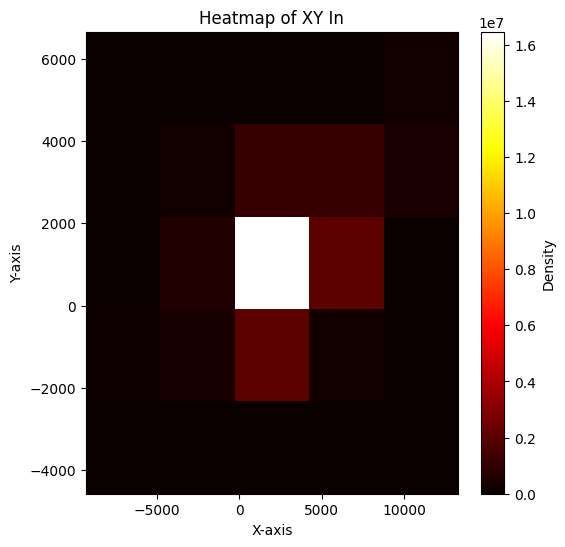

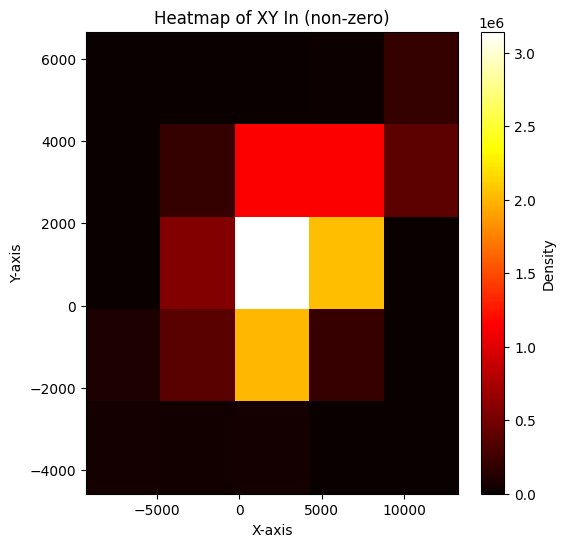

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

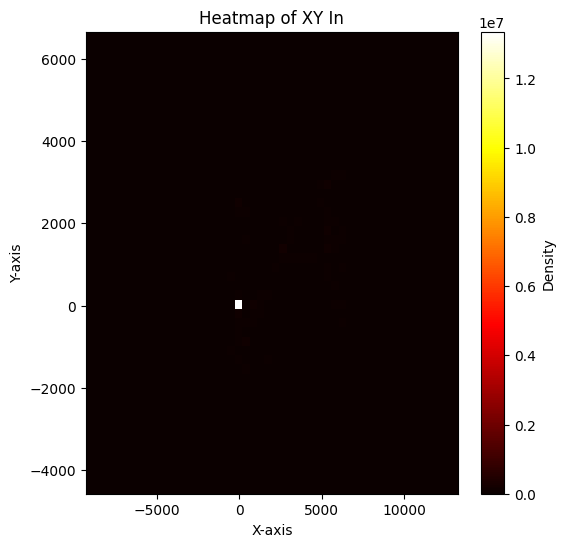

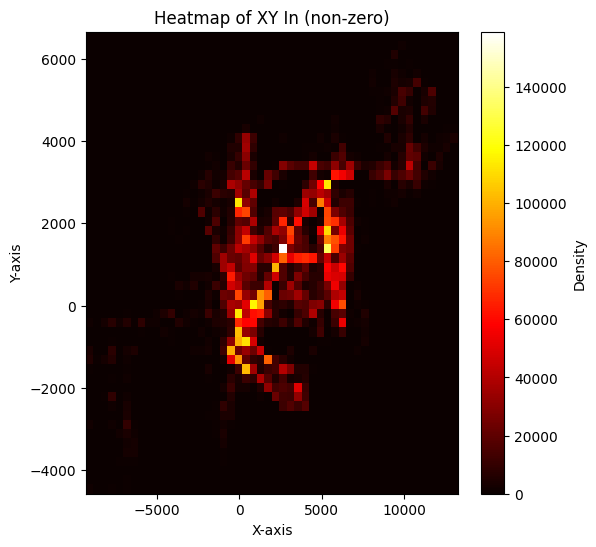

In [8]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [9]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [10]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [11]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [12]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [19]:
model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
early_stopping_patience = 10
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [20]:
for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
      
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step()
    # scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_44160/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_44160/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:08<14:26,  8.75s/epoch]

Epoch 000 | Learning rate 0.000900 | train normalized MSE 32348.1691 | val normalized MSE 19995.1244, | val MAE 607.2967 | val MSE 979761.0918


Epoch:   2%|▏         | 2/100 [00:12<09:21,  5.73s/epoch]

Epoch 001 | Learning rate 0.000810 | train normalized MSE 19288.4353 | val normalized MSE 13344.2347, | val MAE 494.2130 | val MSE 653867.5010


Epoch:   3%|▎         | 3/100 [00:15<07:28,  4.62s/epoch]

Epoch 002 | Learning rate 0.000729 | train normalized MSE 15423.7464 | val normalized MSE 11532.0856, | val MAE 455.9305 | val MSE 565072.1875


Epoch:   4%|▍         | 4/100 [00:18<06:29,  4.05s/epoch]

Epoch 003 | Learning rate 0.000656 | train normalized MSE 11432.1977 | val normalized MSE 10953.6157, | val MAE 430.8470 | val MSE 536727.1680


Epoch:   5%|▌         | 5/100 [00:23<06:47,  4.28s/epoch]

Epoch 004 | Learning rate 0.000590 | train normalized MSE 10157.3435 | val normalized MSE 8057.5363, | val MAE 386.6773 | val MSE 394819.2778


Epoch:   6%|▌         | 6/100 [00:28<07:03,  4.51s/epoch]

Epoch 005 | Learning rate 0.000531 | train normalized MSE 8282.1287 | val normalized MSE 14448.8114, | val MAE 489.2302 | val MSE 707991.7603


Epoch:   7%|▋         | 7/100 [00:33<07:12,  4.65s/epoch]

Epoch 006 | Learning rate 0.000478 | train normalized MSE 6145.2351 | val normalized MSE 4149.3772, | val MAE 282.4245 | val MSE 203319.4763


Epoch:   8%|▊         | 8/100 [00:38<07:14,  4.72s/epoch]

Epoch 007 | Learning rate 0.000430 | train normalized MSE 5343.6939 | val normalized MSE 5331.7325, | val MAE 301.4062 | val MSE 261254.8992


Epoch:   9%|▉         | 9/100 [00:42<07:06,  4.68s/epoch]

Epoch 008 | Learning rate 0.000387 | train normalized MSE 4944.2573 | val normalized MSE 4138.3860, | val MAE 283.4681 | val MSE 202780.9211


Epoch:  10%|█         | 10/100 [00:47<06:58,  4.65s/epoch]

Epoch 009 | Learning rate 0.000349 | train normalized MSE 3590.3367 | val normalized MSE 2440.3862, | val MAE 210.7851 | val MSE 119578.9219


Epoch:  11%|█         | 11/100 [00:52<06:57,  4.69s/epoch]

Epoch 010 | Learning rate 0.000314 | train normalized MSE 2887.4013 | val normalized MSE 4324.5169, | val MAE 281.2340 | val MSE 211901.3259


Epoch:  12%|█▏        | 12/100 [00:57<07:00,  4.78s/epoch]

Epoch 011 | Learning rate 0.000282 | train normalized MSE 2823.4899 | val normalized MSE 2369.1498, | val MAE 211.1449 | val MSE 116088.3403


Epoch:  13%|█▎        | 13/100 [01:01<06:51,  4.73s/epoch]

Epoch 012 | Learning rate 0.000254 | train normalized MSE 2240.4576 | val normalized MSE 1569.6175, | val MAE 183.7535 | val MSE 76911.2585


Epoch:  14%|█▍        | 14/100 [01:05<06:08,  4.29s/epoch]

Epoch 013 | Learning rate 0.000229 | train normalized MSE 1722.7288 | val normalized MSE 2507.0477, | val MAE 201.1344 | val MSE 122845.3416


Epoch:  15%|█▌        | 15/100 [01:10<06:34,  4.64s/epoch]

Epoch 014 | Learning rate 0.000206 | train normalized MSE 1581.5058 | val normalized MSE 1208.0040, | val MAE 157.4540 | val MSE 59192.1973


Epoch:  16%|█▌        | 16/100 [01:16<06:49,  4.87s/epoch]

Epoch 015 | Learning rate 0.000185 | train normalized MSE 1339.4990 | val normalized MSE 1239.4761, | val MAE 155.2680 | val MSE 60734.3270


Epoch:  17%|█▋        | 17/100 [01:21<06:48,  4.92s/epoch]

Epoch 016 | Learning rate 0.000167 | train normalized MSE 1052.0846 | val normalized MSE 1525.4927, | val MAE 166.9593 | val MSE 74749.1410


Epoch:  18%|█▊        | 18/100 [01:26<06:50,  5.01s/epoch]

Epoch 017 | Learning rate 0.000150 | train normalized MSE 888.5375 | val normalized MSE 642.0189, | val MAE 113.0865 | val MSE 31458.9276


Epoch:  19%|█▉        | 19/100 [01:31<06:50,  5.07s/epoch]

Epoch 018 | Learning rate 0.000135 | train normalized MSE 792.9788 | val normalized MSE 958.1854, | val MAE 135.0649 | val MSE 46951.0842


Epoch:  20%|██        | 20/100 [01:36<06:52,  5.16s/epoch]

Epoch 019 | Learning rate 0.000122 | train normalized MSE 632.8211 | val normalized MSE 810.1974, | val MAE 124.3094 | val MSE 39699.6695


Epoch:  21%|██        | 21/100 [01:41<06:42,  5.09s/epoch]

Epoch 020 | Learning rate 0.000109 | train normalized MSE 582.6264 | val normalized MSE 542.9555, | val MAE 104.2470 | val MSE 26604.8213


Epoch:  22%|██▏       | 22/100 [01:46<06:31,  5.02s/epoch]

Epoch 021 | Learning rate 0.000098 | train normalized MSE 519.9317 | val normalized MSE 481.6508, | val MAE  98.2882 | val MSE 23600.8918


Epoch:  23%|██▎       | 23/100 [01:49<05:45,  4.49s/epoch]

Epoch 022 | Learning rate 0.000089 | train normalized MSE 467.6891 | val normalized MSE 550.4324, | val MAE 101.2089 | val MSE 26971.1877


Epoch:  24%|██▍       | 24/100 [01:53<05:12,  4.11s/epoch]

Epoch 023 | Learning rate 0.000080 | train normalized MSE 385.7838 | val normalized MSE 362.0406, | val MAE  87.5291 | val MSE 17739.9914


Epoch:  25%|██▌       | 25/100 [01:57<05:16,  4.22s/epoch]

Epoch 024 | Learning rate 0.000072 | train normalized MSE 344.7847 | val normalized MSE 384.4784, | val MAE  91.6376 | val MSE 18839.4395


Epoch:  26%|██▌       | 26/100 [02:02<05:33,  4.50s/epoch]

Epoch 025 | Learning rate 0.000065 | train normalized MSE 302.2643 | val normalized MSE 361.6283, | val MAE  84.9930 | val MSE 17719.7860


Epoch:  27%|██▋       | 27/100 [02:07<05:29,  4.52s/epoch]

Epoch 026 | Learning rate 0.000058 | train normalized MSE 274.8055 | val normalized MSE 314.6436, | val MAE  80.2651 | val MSE 15417.5384


Epoch:  28%|██▊       | 28/100 [02:12<05:30,  4.59s/epoch]

Epoch 027 | Learning rate 0.000052 | train normalized MSE 247.0688 | val normalized MSE 265.9795, | val MAE  73.6792 | val MSE 13032.9939


Epoch:  29%|██▉       | 29/100 [02:15<05:04,  4.29s/epoch]

Epoch 028 | Learning rate 0.000047 | train normalized MSE 228.9816 | val normalized MSE 256.3300, | val MAE  74.2990 | val MSE 12560.1682


Epoch:  30%|███       | 30/100 [02:19<04:42,  4.04s/epoch]

Epoch 029 | Learning rate 0.000042 | train normalized MSE 206.3461 | val normalized MSE 264.2378, | val MAE  73.1002 | val MSE 12947.6542


Epoch:  31%|███       | 31/100 [02:25<05:20,  4.64s/epoch]

Epoch 030 | Learning rate 0.000038 | train normalized MSE 195.1504 | val normalized MSE 233.0440, | val MAE  69.3393 | val MSE 11419.1553


Epoch:  32%|███▏      | 32/100 [02:29<05:12,  4.60s/epoch]

Epoch 031 | Learning rate 0.000034 | train normalized MSE 180.0890 | val normalized MSE 250.3280, | val MAE  70.7823 | val MSE 12266.0740


Epoch:  33%|███▎      | 33/100 [02:34<05:19,  4.76s/epoch]

Epoch 032 | Learning rate 0.000031 | train normalized MSE 168.8396 | val normalized MSE 212.8966, | val MAE  65.7809 | val MSE 10431.9333


Epoch:  34%|███▍      | 34/100 [02:39<05:20,  4.85s/epoch]

Epoch 033 | Learning rate 0.000028 | train normalized MSE 156.8875 | val normalized MSE 206.2027, | val MAE  64.9230 | val MSE 10103.9326


Epoch:  35%|███▌      | 35/100 [02:44<05:18,  4.89s/epoch]

Epoch 034 | Learning rate 0.000025 | train normalized MSE 147.1813 | val normalized MSE 193.5184, | val MAE  63.6857 | val MSE 9482.4023


Epoch:  36%|███▌      | 36/100 [02:49<05:10,  4.84s/epoch]

Epoch 035 | Learning rate 0.000023 | train normalized MSE 138.1620 | val normalized MSE 202.2742, | val MAE  63.8824 | val MSE 9911.4357


Epoch:  37%|███▋      | 37/100 [02:54<05:09,  4.91s/epoch]

Epoch 036 | Learning rate 0.000020 | train normalized MSE 130.6427 | val normalized MSE 187.5223, | val MAE  62.2856 | val MSE 9188.5912


Epoch:  38%|███▊      | 38/100 [02:58<04:49,  4.66s/epoch]

Epoch 037 | Learning rate 0.000018 | train normalized MSE 124.4271 | val normalized MSE 196.0847, | val MAE  63.0009 | val MSE 9608.1486


Epoch:  39%|███▉      | 39/100 [03:02<04:36,  4.53s/epoch]

Epoch 038 | Learning rate 0.000016 | train normalized MSE 119.2673 | val normalized MSE 180.5240, | val MAE  60.8907 | val MSE 8845.6776


Epoch:  40%|████      | 40/100 [03:07<04:32,  4.54s/epoch]

Epoch 039 | Learning rate 0.000015 | train normalized MSE 115.0389 | val normalized MSE 174.2788, | val MAE  59.5989 | val MSE 8539.6620


Epoch:  41%|████      | 41/100 [03:12<04:34,  4.66s/epoch]

Epoch 040 | Learning rate 0.000013 | train normalized MSE 110.5026 | val normalized MSE 168.5773, | val MAE  58.8073 | val MSE 8260.2872


Epoch:  42%|████▏     | 42/100 [03:17<04:33,  4.71s/epoch]

Epoch 041 | Learning rate 0.000012 | train normalized MSE 107.2422 | val normalized MSE 161.2707, | val MAE  57.3992 | val MSE 7902.2645


Epoch:  43%|████▎     | 43/100 [03:21<04:26,  4.68s/epoch]

Epoch 042 | Learning rate 0.000011 | train normalized MSE 103.2253 | val normalized MSE 165.8582, | val MAE  58.0739 | val MSE 8127.0502


Epoch:  44%|████▍     | 44/100 [03:26<04:20,  4.65s/epoch]

Epoch 043 | Learning rate 0.000010 | train normalized MSE 100.4217 | val normalized MSE 157.7429, | val MAE  56.7929 | val MSE 7729.4046


Epoch:  45%|████▌     | 45/100 [03:30<04:08,  4.52s/epoch]

Epoch 044 | Learning rate 0.000009 | train normalized MSE  97.9629 | val normalized MSE 161.5552, | val MAE  57.3270 | val MSE 7916.2048


Epoch:  46%|████▌     | 46/100 [03:34<03:58,  4.42s/epoch]

Epoch 045 | Learning rate 0.000008 | train normalized MSE  95.7552 | val normalized MSE 159.0300, | val MAE  56.8510 | val MSE 7792.4695


Epoch:  47%|████▋     | 47/100 [03:39<03:53,  4.40s/epoch]

Epoch 046 | Learning rate 0.000007 | train normalized MSE  93.6289 | val normalized MSE 151.7250, | val MAE  55.5067 | val MSE 7434.5258


Epoch:  48%|████▊     | 48/100 [03:43<03:47,  4.38s/epoch]

Epoch 047 | Learning rate 0.000006 | train normalized MSE  91.7833 | val normalized MSE 150.2689, | val MAE  55.1833 | val MSE 7363.1749


Epoch:  49%|████▉     | 49/100 [03:47<03:40,  4.32s/epoch]

Epoch 048 | Learning rate 0.000006 | train normalized MSE  89.8360 | val normalized MSE 149.7708, | val MAE  55.0934 | val MSE 7338.7708


Epoch:  50%|█████     | 50/100 [03:51<03:34,  4.30s/epoch]

Epoch 049 | Learning rate 0.000005 | train normalized MSE  88.8673 | val normalized MSE 146.3580, | val MAE  54.4874 | val MSE 7171.5433


Epoch:  51%|█████     | 51/100 [03:56<03:35,  4.39s/epoch]

Epoch 050 | Learning rate 0.000005 | train normalized MSE  86.7985 | val normalized MSE 146.2565, | val MAE  54.4214 | val MSE 7166.5663


Epoch:  52%|█████▏    | 52/100 [04:00<03:26,  4.31s/epoch]

Epoch 051 | Learning rate 0.000004 | train normalized MSE  85.4724 | val normalized MSE 144.4305, | val MAE  54.0767 | val MSE 7077.0949


Epoch:  53%|█████▎    | 53/100 [04:04<03:22,  4.30s/epoch]

Epoch 052 | Learning rate 0.000004 | train normalized MSE  84.8502 | val normalized MSE 144.7548, | val MAE  54.1400 | val MSE 7092.9856


Epoch:  54%|█████▍    | 54/100 [04:09<03:22,  4.40s/epoch]

Epoch 053 | Learning rate 0.000003 | train normalized MSE  83.5088 | val normalized MSE 143.2800, | val MAE  53.7923 | val MSE 7020.7208


Epoch:  55%|█████▌    | 55/100 [04:14<03:20,  4.46s/epoch]

Epoch 054 | Learning rate 0.000003 | train normalized MSE  82.7566 | val normalized MSE 142.8016, | val MAE  53.6845 | val MSE 6997.2773


Epoch:  56%|█████▌    | 56/100 [04:19<03:25,  4.66s/epoch]

Epoch 055 | Learning rate 0.000003 | train normalized MSE  81.2558 | val normalized MSE 140.8147, | val MAE  53.3188 | val MSE 6899.9180


Epoch:  57%|█████▋    | 57/100 [04:22<03:06,  4.35s/epoch]

Epoch 056 | Learning rate 0.000002 | train normalized MSE  80.9612 | val normalized MSE 141.5492, | val MAE  53.4625 | val MSE 6935.9095


Epoch:  58%|█████▊    | 58/100 [04:28<03:19,  4.76s/epoch]

Epoch 057 | Learning rate 0.000002 | train normalized MSE  80.3550 | val normalized MSE 140.8097, | val MAE  53.3650 | val MSE 6899.6753


Epoch:  59%|█████▉    | 59/100 [04:33<03:15,  4.76s/epoch]

Epoch 058 | Learning rate 0.000002 | train normalized MSE  79.9285 | val normalized MSE 140.2403, | val MAE  53.1818 | val MSE 6871.7726


Epoch:  60%|██████    | 60/100 [04:38<03:12,  4.81s/epoch]

Epoch 059 | Learning rate 0.000002 | train normalized MSE  78.9618 | val normalized MSE 139.7242, | val MAE  53.1386 | val MSE 6846.4862


Epoch:  61%|██████    | 61/100 [04:42<03:05,  4.74s/epoch]

Epoch 060 | Learning rate 0.000002 | train normalized MSE  78.3137 | val normalized MSE 139.5194, | val MAE  53.0375 | val MSE 6836.4518


Epoch:  62%|██████▏   | 62/100 [04:47<03:01,  4.79s/epoch]

Epoch 061 | Learning rate 0.000001 | train normalized MSE  77.8927 | val normalized MSE 138.2351, | val MAE  52.7836 | val MSE 6773.5201


Epoch:  63%|██████▎   | 63/100 [04:52<02:54,  4.71s/epoch]

Epoch 062 | Learning rate 0.000001 | train normalized MSE  77.4551 | val normalized MSE 138.7288, | val MAE  52.8618 | val MSE 6797.7125


Epoch:  64%|██████▍   | 64/100 [04:56<02:47,  4.66s/epoch]

Epoch 063 | Learning rate 0.000001 | train normalized MSE  77.5345 | val normalized MSE 138.7061, | val MAE  52.8822 | val MSE 6796.5968


Epoch:  65%|██████▌   | 65/100 [05:01<02:45,  4.73s/epoch]

Epoch 064 | Learning rate 0.000001 | train normalized MSE  76.9069 | val normalized MSE 137.6872, | val MAE  52.6483 | val MSE 6746.6740


Epoch:  66%|██████▌   | 66/100 [05:06<02:37,  4.63s/epoch]

Epoch 065 | Learning rate 0.000001 | train normalized MSE  76.9084 | val normalized MSE 137.6124, | val MAE  52.6320 | val MSE 6743.0098


Epoch:  67%|██████▋   | 67/100 [05:10<02:31,  4.60s/epoch]

Epoch 066 | Learning rate 0.000001 | train normalized MSE  75.8930 | val normalized MSE 137.4963, | val MAE  52.5967 | val MSE 6737.3196


Epoch:  68%|██████▊   | 68/100 [05:14<02:22,  4.45s/epoch]

Epoch 067 | Learning rate 0.000001 | train normalized MSE  76.0544 | val normalized MSE 137.1570, | val MAE  52.5422 | val MSE 6720.6946


Epoch:  69%|██████▉   | 69/100 [05:19<02:17,  4.43s/epoch]

Epoch 068 | Learning rate 0.000001 | train normalized MSE  75.4259 | val normalized MSE 136.7169, | val MAE  52.4657 | val MSE 6699.1306


Epoch:  70%|███████   | 70/100 [05:23<02:10,  4.35s/epoch]

Epoch 069 | Learning rate 0.000001 | train normalized MSE  76.1913 | val normalized MSE 136.8425, | val MAE  52.4839 | val MSE 6705.2830


Epoch:  71%|███████   | 71/100 [05:27<02:04,  4.29s/epoch]

Epoch 070 | Learning rate 0.000001 | train normalized MSE  75.3796 | val normalized MSE 136.5656, | val MAE  52.4304 | val MSE 6691.7161


Epoch:  72%|███████▏  | 72/100 [05:32<02:05,  4.50s/epoch]

Epoch 071 | Learning rate 0.000001 | train normalized MSE  75.6092 | val normalized MSE 136.3739, | val MAE  52.3949 | val MSE 6682.3213


Epoch:  73%|███████▎  | 73/100 [05:37<02:03,  4.57s/epoch]

Epoch 072 | Learning rate 0.000000 | train normalized MSE  74.8265 | val normalized MSE 136.2891, | val MAE  52.3765 | val MSE 6678.1652


Epoch:  74%|███████▍  | 74/100 [05:41<01:58,  4.58s/epoch]

Epoch 073 | Learning rate 0.000000 | train normalized MSE  75.2185 | val normalized MSE 135.9187, | val MAE  52.3073 | val MSE 6660.0143


Epoch:  75%|███████▌  | 75/100 [05:46<01:55,  4.60s/epoch]

Epoch 074 | Learning rate 0.000000 | train normalized MSE  74.7310 | val normalized MSE 136.3400, | val MAE  52.3673 | val MSE 6680.6597


Epoch:  76%|███████▌  | 76/100 [05:50<01:49,  4.55s/epoch]

Epoch 075 | Learning rate 0.000000 | train normalized MSE  74.8278 | val normalized MSE 136.0431, | val MAE  52.3427 | val MSE 6666.1136


Epoch:  77%|███████▋  | 77/100 [05:55<01:43,  4.51s/epoch]

Epoch 076 | Learning rate 0.000000 | train normalized MSE  74.8583 | val normalized MSE 135.8861, | val MAE  52.3024 | val MSE 6658.4183


Epoch:  78%|███████▊  | 78/100 [05:59<01:39,  4.53s/epoch]

Epoch 077 | Learning rate 0.000000 | train normalized MSE  74.8282 | val normalized MSE 135.8895, | val MAE  52.2877 | val MSE 6658.5855


Epoch:  79%|███████▉  | 79/100 [06:05<01:43,  4.92s/epoch]

Epoch 078 | Learning rate 0.000000 | train normalized MSE  74.2057 | val normalized MSE 135.8270, | val MAE  52.2713 | val MSE 6655.5212


Epoch:  80%|████████  | 80/100 [06:10<01:38,  4.93s/epoch]

Epoch 079 | Learning rate 0.000000 | train normalized MSE  74.2482 | val normalized MSE 135.7775, | val MAE  52.2537 | val MSE 6653.0960


Epoch:  81%|████████  | 81/100 [06:16<01:37,  5.12s/epoch]

Epoch 080 | Learning rate 0.000000 | train normalized MSE  74.4721 | val normalized MSE 135.9400, | val MAE  52.2816 | val MSE 6661.0586


Epoch:  82%|████████▏ | 82/100 [06:20<01:29,  4.99s/epoch]

Epoch 081 | Learning rate 0.000000 | train normalized MSE  74.4146 | val normalized MSE 135.5464, | val MAE  52.2269 | val MSE 6641.7723


Epoch:  83%|████████▎ | 83/100 [06:25<01:23,  4.92s/epoch]

Epoch 082 | Learning rate 0.000000 | train normalized MSE  74.6430 | val normalized MSE 135.5533, | val MAE  52.2225 | val MSE 6642.1127


Epoch:  84%|████████▍ | 84/100 [06:30<01:16,  4.80s/epoch]

Epoch 083 | Learning rate 0.000000 | train normalized MSE  74.2448 | val normalized MSE 135.6031, | val MAE  52.2281 | val MSE 6644.5502


Epoch:  85%|████████▌ | 85/100 [06:34<01:07,  4.53s/epoch]

Epoch 084 | Learning rate 0.000000 | train normalized MSE  74.0130 | val normalized MSE 135.4329, | val MAE  52.1980 | val MSE 6636.2136


Epoch:  86%|████████▌ | 86/100 [06:39<01:07,  4.84s/epoch]

Epoch 085 | Learning rate 0.000000 | train normalized MSE  74.2350 | val normalized MSE 135.5967, | val MAE  52.2192 | val MSE 6644.2397


Epoch:  87%|████████▋ | 87/100 [06:44<01:04,  4.98s/epoch]

Epoch 086 | Learning rate 0.000000 | train normalized MSE  73.9365 | val normalized MSE 135.4986, | val MAE  52.2020 | val MSE 6639.4316


Epoch:  88%|████████▊ | 88/100 [06:50<01:00,  5.05s/epoch]

Epoch 087 | Learning rate 0.000000 | train normalized MSE  74.2694 | val normalized MSE 135.4446, | val MAE  52.2032 | val MSE 6636.7870


Epoch:  89%|████████▉ | 89/100 [06:55<00:56,  5.15s/epoch]

Epoch 088 | Learning rate 0.000000 | train normalized MSE  73.9516 | val normalized MSE 135.4119, | val MAE  52.1893 | val MSE 6635.1819


Epoch:  90%|█████████ | 90/100 [07:00<00:51,  5.13s/epoch]

Epoch 089 | Learning rate 0.000000 | train normalized MSE  74.0633 | val normalized MSE 135.3693, | val MAE  52.1789 | val MSE 6633.0975


Epoch:  91%|█████████ | 91/100 [07:04<00:41,  4.62s/epoch]

Epoch 090 | Learning rate 0.000000 | train normalized MSE  73.9989 | val normalized MSE 135.3876, | val MAE  52.1779 | val MSE 6633.9913


Epoch:  92%|█████████▏| 92/100 [07:08<00:35,  4.43s/epoch]

Epoch 091 | Learning rate 0.000000 | train normalized MSE  73.9242 | val normalized MSE 135.3611, | val MAE  52.1816 | val MSE 6632.6929


Epoch:  93%|█████████▎| 93/100 [07:13<00:33,  4.77s/epoch]

Epoch 092 | Learning rate 0.000000 | train normalized MSE  74.0529 | val normalized MSE 135.3475, | val MAE  52.1766 | val MSE 6632.0259


Epoch:  94%|█████████▍| 94/100 [07:18<00:29,  4.93s/epoch]

Epoch 093 | Learning rate 0.000000 | train normalized MSE  74.2005 | val normalized MSE 135.3187, | val MAE  52.1736 | val MSE 6630.6180


Epoch:  95%|█████████▌| 95/100 [07:24<00:25,  5.11s/epoch]

Epoch 094 | Learning rate 0.000000 | train normalized MSE  73.7048 | val normalized MSE 135.3652, | val MAE  52.1809 | val MSE 6632.8960


Epoch:  96%|█████████▌| 96/100 [07:27<00:18,  4.56s/epoch]

Epoch 095 | Learning rate 0.000000 | train normalized MSE  73.6158 | val normalized MSE 135.3246, | val MAE  52.1745 | val MSE 6630.9042


Epoch:  97%|█████████▋| 97/100 [07:33<00:14,  4.89s/epoch]

Epoch 096 | Learning rate 0.000000 | train normalized MSE  73.9062 | val normalized MSE 135.2797, | val MAE  52.1621 | val MSE 6628.7048


Epoch:  98%|█████████▊| 98/100 [07:38<00:10,  5.01s/epoch]

Epoch 097 | Learning rate 0.000000 | train normalized MSE  73.7027 | val normalized MSE 135.3007, | val MAE  52.1660 | val MSE 6629.7363


Epoch:  99%|█████████▉| 99/100 [07:43<00:05,  5.05s/epoch]

Epoch 098 | Learning rate 0.000000 | train normalized MSE  73.6472 | val normalized MSE 135.3053, | val MAE  52.1723 | val MSE 6629.9620


Epoch: 100%|██████████| 100/100 [07:48<00:00,  4.69s/epoch]

Epoch 099 | Learning rate 0.000000 | train normalized MSE  73.8248 | val normalized MSE 135.2726, | val MAE  52.1619 | val MSE 6628.3566


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [18]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

/var/folders/y2/htdgfqkx0076k5jq4wv9rdl00000gn/T/ipykernel_42403/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


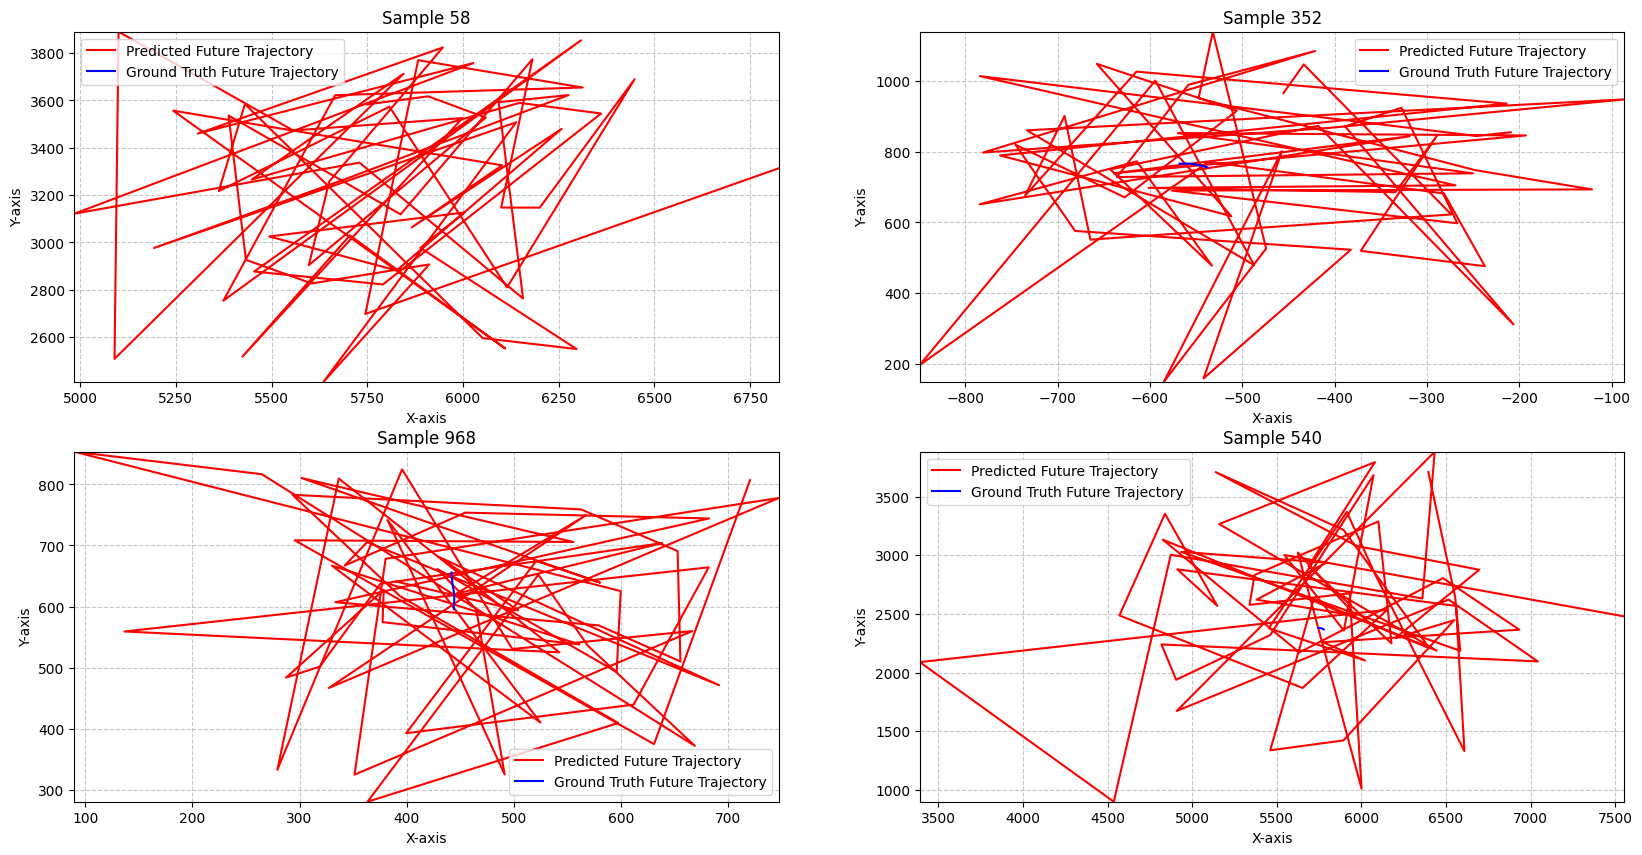

In [19]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [20]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B